In [15]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [16]:
path = os.path.normpath(os.getcwd() + os.sep + os.pardir)

In [17]:
# Helper function for label generation

# Reading in weather data and making sure the weather data is the same length as the non-participants data
def get_weather(location, path):

    weather = pd.DataFrame()
    for file in os.listdir(os.path.join(path, 'Data', 'weather', location)):
        temp = pd.read_csv(os.path.join(path, 'Data', 'weather', location, file))
        temp.index = pd.to_datetime(temp[['Year', 'Month', 'Day', 'Hour', 'Minute']])
        temp = temp.iloc[:, 5:]

        weather = pd.concat((weather, temp))

    weather = weather[['Temperature']]
    weather = weather.resample('1H').interpolate()

    new_date = pd.to_datetime('2017-12-31 23:45')
    new_data = pd.DataFrame(weather[-1:].values, index=[new_date], columns=weather.columns)
    weather = pd.concat((weather, new_data))
    
    return weather
def get_percentage(df):
    
    high = 0
    med = 0
    low = 0
    
    for i in df.columns:
        if df[i].iloc[-3] == 2:
            high+=1
        elif df[i].iloc[-3] == 1:
            med+=1
        elif df[i].iloc[-3] == 0:
            low+=1
            
    high = round(high/len(df.columns), 3)
    med = round(med/len(df.columns), 3)
    low = round(low/len(df.columns), 3)
    
    if high + med + low != 1.0:
        high += 1 -(high + med + low)
    
    return high, med, low

def get_season(i):
    
    if i.month in [11, 12, 1, 2, 3, 4]:
        season = 'Winter'
    elif i.month in [5, 6, 7, 8, 9, 10]:
        season = 'Summer'
    return season


def get_price_label(price, daily_price_label, i):
    
    price_dict = {'Summer': 40, 'Winter': 28}
    season_price = price_dict[get_season(i)]
    
    peak_hour_price = price[15:20].copy()
    
    if (peak_hour_price.values >= season_price).any():
        daily_price_label = 2
    else:
        daily_price_label = 0
    
    return daily_price_label

def get_temperature_label(weather, daily_weather_label, i):
    
    peak_hour_temp = weather.iloc[15:20].copy()
    
    if get_season(i) == 'Summer':
        
        if peak_hour_temp.mean() >= 31.5:
            temperature_label = 2
        elif peak_hour_temp.mean() < 31.5 and peak_hour_temp.mean() >= 29.5:
            temperature_label = 1
        elif peak_hour_temp.mean() < 29.5:
            temperature_label = 0
    
    elif get_season(i) == 'Winter':
        
        if peak_hour_temp.mean() >= 22:
            temperature_label = 0
        elif peak_hour_temp.mean() < 22 and peak_hour_temp.mean() >= 18.75:
            temperature_label = 1
        elif peak_hour_temp.mean() < 18.75:
            temperature_label = 2
           
    return temperature_label

def generate_labels(daily_price, daily_weather, summer_high, summer_med, summer_low, winter_high, winter_med, winter_low):
    
    # Create two empty arrays for the price and temperature labels
    daily_price_label = []
    daily_weather_label = []
    
    # Step through price and temperature by day and determine the appropriate labels by using the same method as before
    for i in daily_price.columns:
        daily_price_label.append( get_price_label(daily_price[i], daily_price_label, i))
        daily_weather_label.append( get_temperature_label(daily_weather[i], daily_weather_label, i))
    
    # Putting together the daily price and temperature labels
    full_label = pd.DataFrame([daily_price_label, daily_weather_label]).T
    # full_label = pd.concat((full_label, pd.DataFrame([[0,0], [0,0]])))
    full_label.index = idx
    
    # Generating the flexibility label by using the probability distribution calculated from the EnergyCoupon experiment or user specified
    flex_label = []
    for i in range(0, len(full_label)):
        if full_label.index[i].month in [11, 12, 1, 2, 3, 4]:
            flex_label.append(np.random.choice(np.arange(0, 3), p=[winter_low, winter_med, winter_high]))
        elif full_label.index[i].month in [5, 6, 7, 8, 9, 10]:
            flex_label.append(np.random.choice(np.arange(0, 3), p=[summer_low, summer_med, summer_high]))
            
    full_label.insert(0, 'flex', flex_label)
    full_label.columns = ['flex', 'price', 'temp']
    full_label.index = full_label.index.rename('time')
    
    return full_label

def create_scenario(scenario, location, summer_low, summer_med, summer_high, winter_low, winter_med, winter_high):
    
    os.makedirs(os.path.join(path, 'Results', 'Generated', f'{location} scenario {scenario}'))
    os.makedirs(os.path.join(path, 'Results', 'Generated', f'{location} scenario {scenario}', 'images'))
    os.makedirs(os.path.join(path, 'Results', 'Generated', f'{location} scenario {scenario}', 'consumption'))
    os.makedirs(os.path.join(path, 'Results', 'Generated', f'{location} scenario {scenario}', 'flexibility'))

    data = pd.DataFrame(data={'Summer Low': summer_low, 'Summer Mid': summer_med, 'Summer High': summer_high, 
                              'Winter Low': winter_low, 'Winter Mid': winter_med, 'Winter High': winter_high}, index=[0])
    data.to_csv(os.path.join(path, 'Results', 'Generated', f'{location} scenario {scenario}', f'{location} scenario {scenario}.csv'), index=False)

    full_label = generate_labels(daily_price, daily_weather, summer_high, summer_med, summer_low, winter_high, winter_med, winter_low)
    full_label.to_csv(os.path.join(path, 'Results', 'Generated', f'{location} scenario {scenario}', f'label - 2017 {location} scenario {scenario}.csv'))
    

def get_daily_value(df):
    temp = pd.DataFrame()
    for day in pd.date_range(df.index[0], df.index[-1], freq='1D'):
        temp.insert(0, day, df.loc[day:day+timedelta(days=1)-timedelta(minutes=15)].values)
    return temp

def generate_new_profiles(non_participants, labels):
    
    for household in non_participants.columns:

        household_df = non_participants[household].copy()

        flexibility = []
        flex_consumption = []
        old_consumption = []

        for day in pd.date_range(household_df.index[0], household_df.index[-1], freq='1D'):

            daily_household = household_df.loc[day:day+timedelta(days=1)-timedelta(minutes=15)].copy()

            daily_label = labels.loc[day].values

            generated_flexibility = generate_flexibility(daily_label, summer_active_generator, summer_inactive_generator, winter_active_generator, winter_inactive_generator)

            generated_flexibility = pd.DataFrame(1 - generated_flexibility)
            generated_flexibility[generated_flexibility < 0] = 0

            flex_household = daily_household.values - (daily_household.values * generated_flexibility.values.reshape(-1, ))

            flexibility = np.concatenate((flexibility, generated_flexibility.values.reshape(-1, )))
            flex_consumption = np.concatenate((flex_consumption, flex_household))
            old_consumption = np.concatenate((old_consumption, daily_household))

        new_household_df = pd.DataFrame(data={'Original Consumption': old_consumption, 'New Consumption': flex_consumption}, index=pd.date_range(household_df.index[0], household_df.index[-1], freq='1H'))

        new_household_df.index = new_household_df.index.rename('time')
        new_household_df.to_csv(os.path.join(path, 'Results', 'Generated', f'{location} scenario {scenario}', 'consumption', f'{household} generated profile.csv'))

        temp_new_df_original = new_household_df['Original Consumption'].copy()
        temp_new_df_new = new_household_df['New Consumption'].copy()

        temp_new_df_original = get_daily_value(temp_new_df_original)
        temp_new_df_new = get_daily_value(temp_new_df_new)

        flexibility = pd.DataFrame(flexibility, index=new_household_df.index, columns=['flexibility'])
        flexibility.to_csv(os.path.join(path, 'Results', 'Generated', f'{location} scenario {scenario}', 'flexibility', f'{household} generated flexibility.csv'))
        
        plt.figure(figsize=(8,5))
        plt.plot(temp_new_df_original, c='blue', lw=0.1, alpha=0.1)
        plt.plot(temp_new_df_original.mean(axis=1), c='blue', label='Old Power Consumption', zorder=10)
        plt.plot(temp_new_df_new, c='red', lw=0.1, alpha=0.1)
        plt.plot(temp_new_df_new.mean(axis=1), c='red', label='New Power Consumption', zorder=10)
        plt.legend()
        plt.title(f'{household}')
        plt.savefig(os.path.join(path, 'Results', 'generated', f'{location} scenario {scenario}', 'images', f'{household}.png'))
        
def generate_flexibility(daily_label, summer_active_generator, summer_inactive_generator, winter_active_generator, winter_inactive_generator):

    z_dim = 32
    hidden_dim = 128
    label_dim = 3
        
    label = torch.from_numpy(np.array([daily_label])).type(torch.LongTensor)
    label_onehot = torch.FloatTensor(1, label_dim).zero_()
    label_onehot = label_onehot.scatter_(1, label, 1).to(device)
    
    z = torch.empty(1, z_dim).normal_().to(device)
    
    if (daily_label[0] == 2) | (daily_label[0] == 1):
        if day.month in [5, 6, 7, 8, 9, 10]:
            fake_samples = summer_active_generator(z, label_onehot)
        elif day.month in [11, 12, 1, 2, 3, 4]:
            fake_samples = winter_active_generator(z, label_onehot)
            fake_samples = 1 - fake_samples
    else:
        if day.month in [5, 6, 7, 8, 9, 10]:
            fake_samples = summer_inactive_generator(z, label_onehot)
        elif day.month in [11, 12, 1, 2, 3, 4]:
            fake_samples = winter_inactive_generator(z, label_onehot)
            fake_samples = 1 - fake_samples
    
    fake_data = fake_samples.cpu().data.numpy().T
    fake_data[fake_data < 0] = 1
    
    return fake_data

In [18]:
# Reading and picking out one year of non-participants' data. 

non_participants = pd.read_csv(os.path.join(path, 'Data', 'nonparticipants.csv'), index_col='time')
non_participants.index = pd.to_datetime(non_participants.index)
non_participants = non_participants.resample('1H').sum()
non_participants = non_participants.iloc[-8784:]

The `location` variable is the city name, it is also the folder name where the weather data is stored. If the data is downloaded from NSRDB (https://nsrdb.nrel.gov/), the code should be able to process the data.

The `load_zone` variable is for the electricity price. Currently, the code can only handle ERCOT load zone data. To move outside of Texas, pre-process the price data so the index column name is `time` and the columns for each load zone follows the format `LZ_*`, the code should be able to run.

In [35]:
# Creating df wiht non-participants data and weather, also reformatting the price and weather data into daily data frames

# Change the city here
location = 'Amarillo' # Weather file, the folder name should be the city name
load_zone = 'west' # Price file, currently the code is set up for only ERCOT load zones. If moved to other states, the price dataframe header might need to be changed

# location = 'Houston'
# load_zone = 'Houston'

price = pd.read_csv(os.path.join(path, 'Data', 'Price', 'price.csv'), index_col='time')
price.index = pd.to_datetime(price.index)
price = price.resample('1H').mean()
price = price.interpolate()

weather = get_weather(location, path)

df = price.join(weather).dropna()
df = df[[f'LZ_{load_zone.upper()}', 'Temperature']]
df = df.loc[df.index.intersection(non_participants.index)]

idx = pd.date_range(df.index[0], df.index[-1])

daily_price = pd.DataFrame()
daily_weather = pd.DataFrame()

for day in idx:
    
    if (len(df[f'LZ_{load_zone.upper()}'].loc[day:day+timedelta(days=1)-timedelta(minutes=15)].values) != 24) | (len(df['Temperature'].loc[day:day+timedelta(days=1)-timedelta(minutes=15)].values) != 24):
        continue
    else:
        daily_price.insert(0, day, df[f'LZ_{load_zone.upper()}'].loc[day:day+timedelta(days=1)-timedelta(minutes=15)].values)
        daily_weather.insert(0, day, df['Temperature'].loc[day:day+timedelta(days=1)-timedelta(minutes=15)].values)

C:\Users\sienna\AppData\Local\Temp\ipykernel_23668\3625524604.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  daily_price.insert(0, day, df[f'LZ_{load_zone.upper()}'].loc[day:day+timedelta(days=1)-timedelta(minutes=15)].values)
C:\Users\sienna\AppData\Local\Temp\ipykernel_23668\3625524604.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  daily_weather.insert(0, day, df['Temperature'].loc[day:day+timedelta(days=1)-timedelta(minutes=15)].values)


In [36]:
z_dim = 32
hidden_dim = 128
label_dim = 3

class generator(nn.Module):
    def __init__(self,z_dim = z_dim, label_dim=label_dim,hidden_dim =hidden_dim):
        super(generator,self).__init__()
        self.net = nn.Sequential(
                    nn.Linear(z_dim+label_dim, hidden_dim),
                    # nn.BatchNorm1d(hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, 24))
        
    def forward(self, input, label_onehot):
        x = torch.cat([input, label_onehot], 1)
        return self.net(x)

summer_active_generator = generator().to(device) 
summer_inactive_generator = generator().to(device) 
winter_active_generator = generator().to(device) 
winter_inactive_generator = generator().to(device) 

summer_active_generator = torch.load(os.path.join(path, 'Code', 'Final Generators', 'Summer Active Group Generator'))
summer_inactive_generator = torch.load(os.path.join(path, 'Code', 'Final Generators', 'Summer Inactive Group Generator'))
winter_active_generator = torch.load(os.path.join(path, 'Code', 'Final Generators', 'Winter Active Group Generator'))
winter_inactive_generator = torch.load(os.path.join(path, 'Code', 'Final Generators', 'Winter Inactive Group Generator'))

Once the location and load zone have been selected and the generators have been loaded, to generate more scenarios, only the two following cells are needed. The first cell allows the user to specify desired flexibility distribution mix, the second cell generates and stores the new profiles.

In [43]:
# Calculate the Summer and Winter flexibility distribution
summer_percentage = pd.read_csv(os.path.join(path, 'Data', 'Flexibility', 'Summer Full.csv'))
winter_percentage = pd.read_csv(os.path.join(path, 'Data', 'Flexibility', 'Winter Full.csv'))

# To use flexibility distribution from EnergyCoupon data, use the following two lines of code
# summer_high, summer_med, summer_low = get_percentage(summer_percentage)
# winter_high, winter_med, winter_low = get_percentage(winter_percentage)

# User defined flexibility distribution
winter_low, winter_med, winter_high = 0.2, 0.3, 0.5
summer_low, summer_med, summer_high = 0.2, 0.3, 0.5

# winter_low, winter_med, winter_high = 0.1, 0.2, 0.7
# summer_low, summer_med, summer_high = 0.1, 0.2, 0.7

# Creates a folder with new labels, scenario summary, and folders that will store the results from the cGAN model
scenario = 2
create_scenario(scenario, location, summer_low, summer_med, summer_high, winter_low, winter_med, winter_high)

C:\Users\sienna\AppData\Local\Temp\ipykernel_23668\3998278001.py:140: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp.insert(0, day, df.loc[day:day+timedelta(days=1)-timedelta(minutes=15)].values)
C:\Users\sienna\AppData\Local\Temp\ipykernel_23668\3998278001.py:140: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp.insert(0, day, df.loc[day:day+timedelta(days=1)-timedelta(minutes=15)].values)
C:\Users\sienna\AppData\Local\Temp\ipykernel_23668\3998278001.py:140: PerformanceWarning: DataFrame is highly fragmented.  This is usu

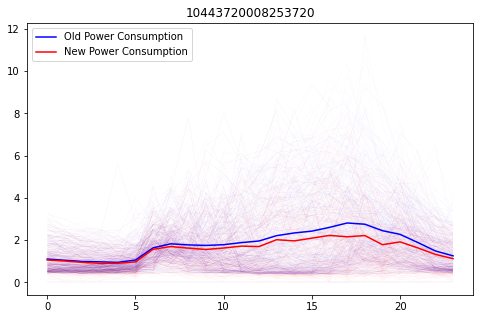

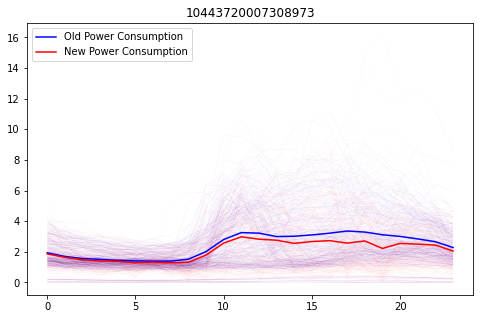

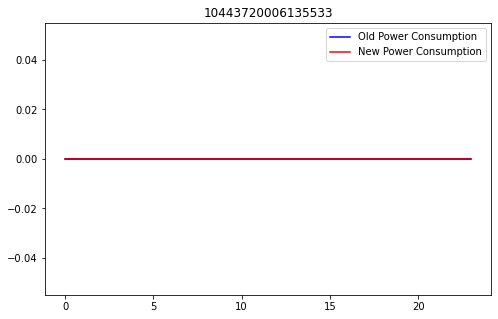

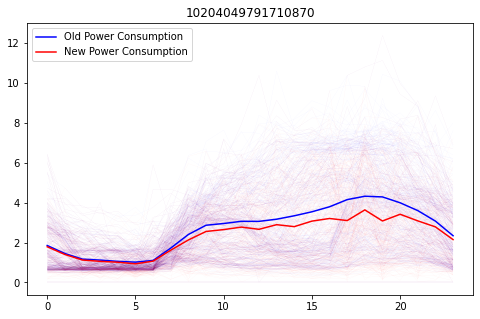

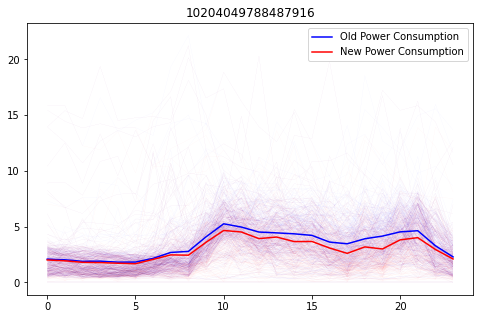

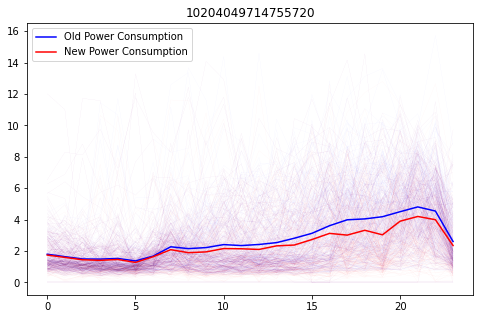

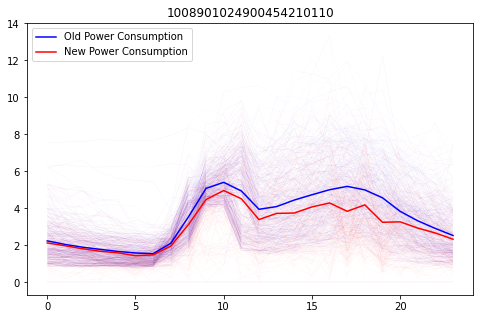

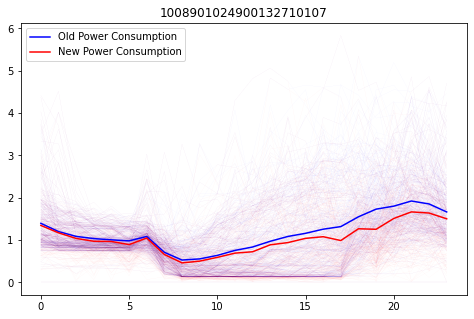

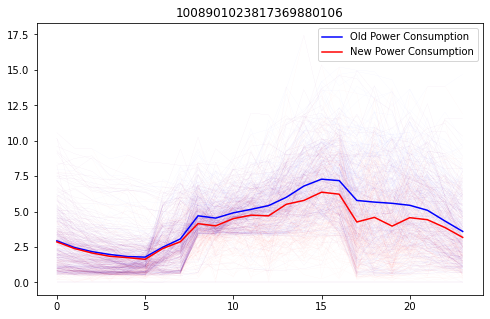

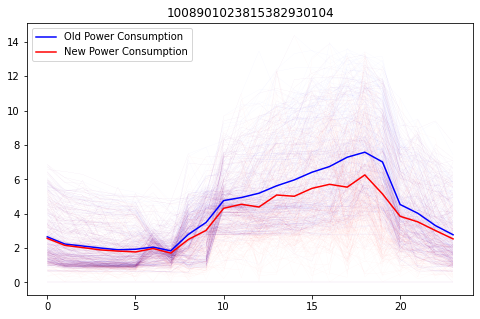

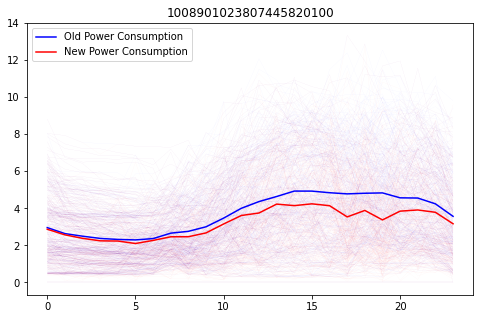

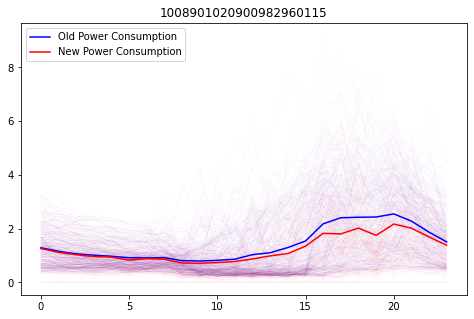

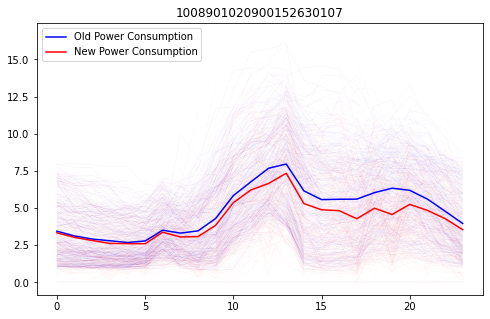

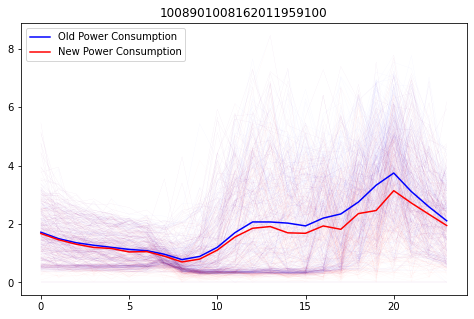

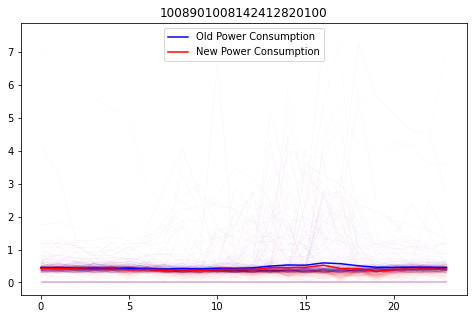

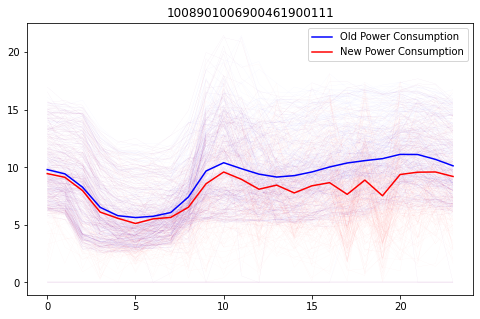

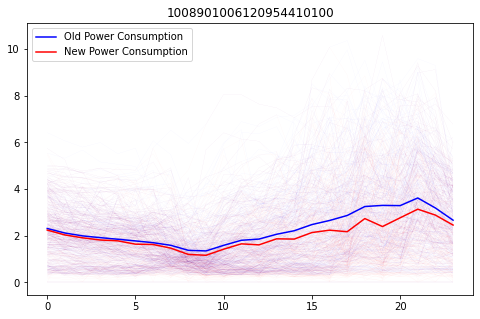

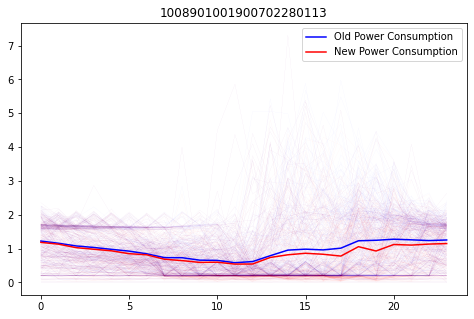

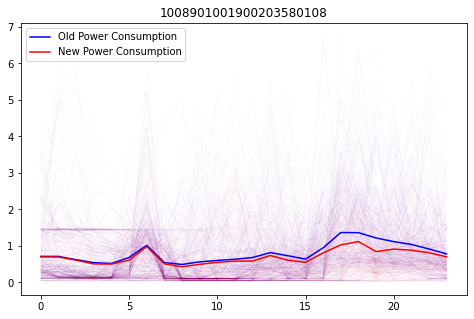

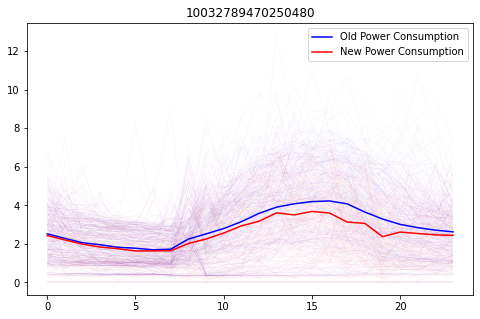

In [44]:
labels = pd.read_csv(os.path.join(path, 'Results', 'Generated', f'{location} scenario {scenario}', f'label - 2017 {location} scenario {scenario}.csv'), index_col='time')
labels.index = pd.to_datetime(labels.index)

generate_new_profiles(non_participants, labels)